## Business Objective:

T and major objective is what are the attributes that travelers are considering while selecting a hotel. With this manager can understand which elements of their hotel influence more in forming a positive review or improves hotel brand image.


## Importing Libraries

In [2]:
import string
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import tensorflow as tf
import pickle
from wordcloud import WordCloud
import plotly.express as px
from plotly.subplots import make_subplots

# Preprocessing and evaluation
from nltk.corpus import stopwords
from nltk.stem.snowball import SnowballStemmer
from nltk.stem.wordnet import WordNetLemmatizer
from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_score
from sklearn.preprocessing import LabelBinarizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import confusion_matrix, classification_report
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.regularizers import l1, l2

# Models
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import BernoulliNB
from sklearn.naive_bayes import MultinomialNB
from sklearn.neural_network import MLPClassifier

In [3]:
df = pd.read_excel('/content/hotel_reviews.xlsx')
df.head(100)

,Review,Rating
0,nice hotel expensive parking got good deal sta...,4
1,ok nothing special charge diamond member hilto...,2
2,nice rooms not 4* experience hotel monaco seat...,3
3,"unique, great stay, wonderful time hotel monac...",5
4,"great stay great stay, went seahawk game aweso...",5
...,...,...
95,"excellent stay staff friendly helpful, nice ho...",4
96,return going seattle booked hotel knowing budg...,4
97,terrible hotel approximately 2 weeks ago april...,1
98,great price okay experience stayed inn queen a...,3


In [4]:
df2 = df.copy()

In [39]:
df.describe()

,Length
count,20491.000000
mean,660.971402
std,623.574911
min,32.000000
25%,311.000000
50%,491.000000
75%,786.000000
max,12281.000000


In [40]:
df.isnull().sum()

Review    0
Rating    0
Length    0
dtype: int64

As you can see from above details,there is no null values in this dataset

## EDA And Text Preprocessing

In [5]:
# Count reviews by Rating
x = df.Rating.value_counts().reset_index().rename(columns={'index': 'Rating', 'Rating': 'Count'})
fig = px.bar(x, 
             x="Rating", 
             y="Count", 
             color="Rating", 
             color_continuous_scale=["#EF553B", "#FFA15A", "#FECB52", "#B6E880", "#00CC96"],
             title="Reviews by rating"
            )


fig.update_layout(
    autosize=False,
    width=1200,
    height=600,
    margin=dict(l=0,r=0,b=0)
)

fig.update_layout(coloraxis_showscale=False)

fig.show()

In [6]:
# Length of word in sentence
df['Length'] = df['Review'].apply(len)
df.head()

,Review,Rating,Length
0,nice hotel expensive parking got good deal sta...,4,593
1,ok nothing special charge diamond member hilto...,2,1689
2,nice rooms not 4* experience hotel monaco seat...,3,1427
3,"unique, great stay, wonderful time hotel monac...",5,600
4,"great stay great stay, went seahawk game aweso...",5,1281


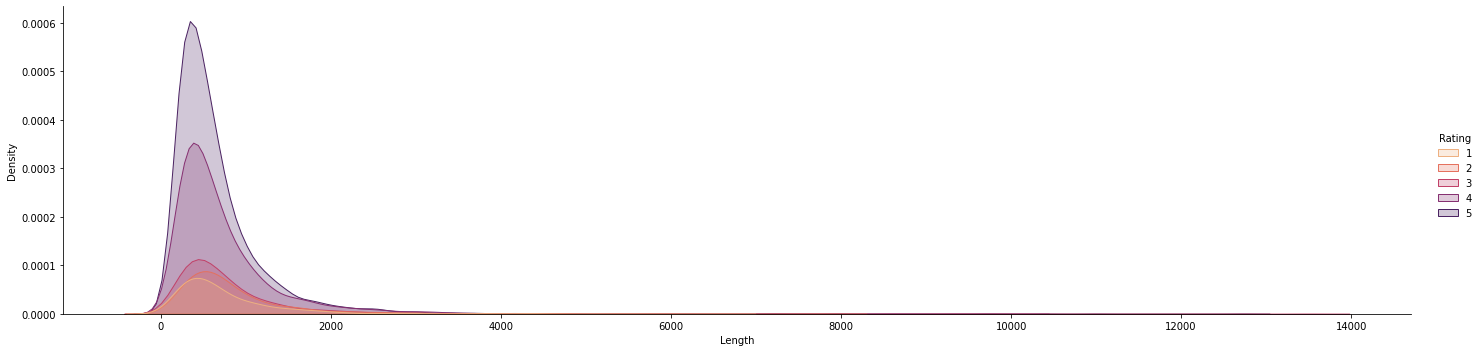

In [7]:
sns.displot(data=df, x='Length', hue='Rating', palette='flare', kind='kde', fill=True, aspect=4)

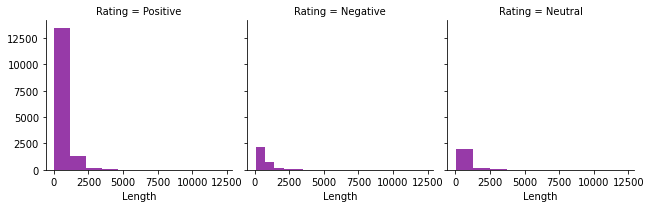

In [41]:
g = sns.FacetGrid(data=df, col='Rating')
g.map(plt.hist, 'Length', color='#973aa8')

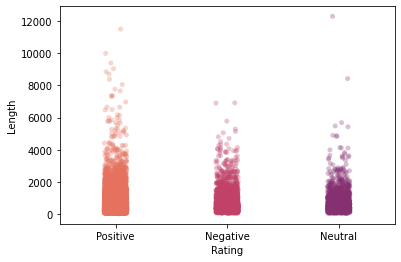

In [42]:
sns.stripplot(data=df, x='Rating', y='Length', palette='flare', alpha=0.3)

From above plot we can say that the rating of the hotel, the more likely the visitors wrote a long review.

In [8]:
# Let's change the rating to be more general and easier to understand
def ratings(score):
    if score > 3:
        return 'Positive'
    elif score == 3:
        return 'Neutral'
    else:
        return 'Negative'

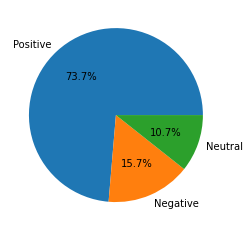

In [9]:
df['Rating'] = df['Rating'].apply(ratings)
plt.pie(df['Rating'].value_counts(), labels=df['Rating'].unique().tolist(), autopct='%1.1f%%')
plt.show()

positive reviews = 73.7%

Negative reviews = 15.7%

Neutral reviews = 10.7%

In [43]:
df.head(20)

,Review,Rating,Length
0,nice hotel expensive park get good deal stay h...,Positive,512
1,ok nothing special charge diamond member hilto...,Negative,1538
2,nice room 4 experience hotel monaco seattle go...,Neutral,1325
3,unique great stay wonderful time hotel monaco ...,Positive,546
4,great stay great stay go seahawk game awesome ...,Positive,1117
5,love monaco staff husband stay hotel crazy wee...,Positive,927
6,cozy stay rainy city husband spend 7 nights mo...,Positive,676
7,excellent staff housekeep quality hotel chock ...,Positive,548
8,hotel stay hotel monaco cruise room generous d...,Positive,386
9,excellent stay hotel monaco past delight recep...,Positive,255


In [44]:
# Total word in dataset before cleaning
length = df['Length'].sum()
length

13543965

In [10]:
import nltk
nltk.download('wordnet')
nltk.download('omw-1.4')
nltk.download('stopwords')

[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

In [11]:
from nltk.tokenize import TweetTokenizer, word_tokenize
nltk.download('punkt')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


True

In [12]:

def create_corpus_df(df):
    corpus = []
    
    
    for i in range(df.shape[0]):
        words = word_tokenize(df.loc[i, 'Review'])
        rating = df.loc[i, 'Rating']
        
        for w in words:
            corpus.append([w, rating])
            
    return np.asarray(corpus)

In [13]:
corpus = create_corpus_df(df)

In [14]:
corpus_df = pd.DataFrame(corpus, columns=['token', 'rating'])

## Top Common Stopwords

In [15]:
def get_stopwords_from_corpus(corpus_df, n=10):
    stop = set(stopwords.words('english'))
    
    corpus_stop_df = corpus_df[corpus_df['token'].isin(stop)].copy()
    
    corpus_stop_df['count'] = 1
    
    corpus_stop_df = corpus_stop_df.groupby(by=['token', 'rating']).count().reset_index().sort_values('count', ascending=False)

    tokens = corpus_stop_df['token'].unique().tolist()[:n]
        
    return corpus_stop_df[corpus_stop_df['token'].isin(tokens)]

In [16]:
color_map = {
                "1": "#EF553B",
                "2": "#FFA15A",
                "3": "#FECB52",
                "4": "#B6E880",
                "5": "#00CC96"
            }

In [17]:
x = get_stopwords_from_corpus(corpus_df, n=5)

fig = px.bar(x, 
             x="token", 
             y="count", 
             color="rating", 
             color_discrete_map=color_map,
             title="Top common stopwords"
            )


fig.update_layout(
    autosize=False,
    width=1000,
    height=500,
    margin=dict(l=0,r=0,b=0),
    barmode='group'
)

fig.show()

## Top Common Words

In [18]:
def get_common_words_from_corpus(corpus_df, n_top=20):
    stop = set(stopwords.words('english'))
    puncts = word_tokenize(string.punctuation)
    
    corpus_stop_df = corpus_df[(~corpus_df['token'].isin(stop)) & (~corpus_df['token'].isin(puncts))].copy()
    
    corpus_stop_df['count'] = 1
    
    corpus_stop_df = corpus_stop_df.groupby(by=['token', 'rating']).count().reset_index().sort_values('count', ascending=False)

    tokens = corpus_stop_df['token'].unique().tolist()[:n_top]
    
    return corpus_stop_df[corpus_stop_df['token'].isin(tokens)]

In [19]:
x = common_words = get_common_words_from_corpus(corpus_df, n_top=10)

fig = px.bar(x, x="token", y="count", color="rating", color_discrete_map=color_map, title="Top common words")


fig.update_layout(
    autosize=False,
    width=800,
    height=500,
    margin=dict(l=0,r=0,b=0),
    barmode='group'
)                                                                                       

fig.show()

## Common punctuation count

In [20]:
def get_common_punctuations_from_corpus(corpus_df):
    puncts = word_tokenize(string.punctuation)
    
    corpus_stop_df = corpus_df[corpus_df['token'].isin(puncts)].copy()
    
    corpus_stop_df['count'] = 1
    
    corpus_stop_df = corpus_stop_df.groupby(by=['token', 'rating']).count().reset_index().sort_values('count', ascending=False)
    
    return corpus_stop_df

In [21]:
x = get_common_punctuations_from_corpus(corpus_df)

x.groupby('token')['count'].sum()

token
'        64
*       680
+        10
,    246646
:         1
`        95
Name: count, dtype: int64

## Lemmatize the word

In [22]:
print('Original:')
print(df['Review'][0])
print()

sentence = []
for word in df['Review'][0].split():
    stemmer = SnowballStemmer('english')
    sentence.append(stemmer.stem(word))
print('Stemming:')
print(' '.join(sentence))
print()

sentence = []
for word in df['Review'][0].split():
    lemmatizer = WordNetLemmatizer()
    sentence.append(lemmatizer.lemmatize(word, 'v'))
print('Lemmatization:')
print(' '.join(sentence))

Original:
nice hotel expensive parking got good deal stay hotel anniversary, arrived late evening took advice previous reviews did valet parking, check quick easy, little disappointed non-existent view room room clean nice size, bed comfortable woke stiff neck high pillows, not soundproof like heard music room night morning loud bangs doors opening closing hear people talking hallway, maybe just noisy neighbors, aveda bath products nice, did not goldfish stay nice touch taken advantage staying longer, location great walking distance shopping, overall nice experience having pay 40 parking night,  

Stemming:
nice hotel expens park got good deal stay hotel anniversary, arriv late even took advic previous review did valet parking, check quick easy, littl disappoint non-exist view room room clean nice size, bed comfort woke stiff neck high pillows, not soundproof like heard music room night morn loud bang door open close hear peopl talk hallway, mayb just noisi neighbors, aveda bath produc

In [23]:
def cleaning(text):
    #remove punctuations and uppercase
    clean_text = text.translate(str.maketrans('','',string.punctuation)).lower()
    
    #remove stopwords
    clean_text = [word for word in clean_text.split() if word not in stopwords.words('english')]
    
    #lemmatize the word
    sentence = []
    for word in clean_text:
        lemmatizer = WordNetLemmatizer()
        sentence.append(lemmatizer.lemmatize(word, 'v'))

    return ' '.join(sentence)

In [24]:
df['Review'] = df['Review'].apply(cleaning)



In [26]:
# Total word in dataset before cleaning
length = df['Length'].sum()
length

13543965

In [27]:
df['Length'] = df['Review'].apply(len)
new_length = df['Length'].sum()
print('Total text length before cleaning: {}'.format(length))
print('Total text length after cleaning: {}'.format(new_length))

Total text length before cleaning: 13543965
Total text length after cleaning: 13543965


## Remove Punctuation

In [28]:
def remove_punctuation(df1):
    
    # remove punctuations
    table = str.maketrans('', '', string.punctuation)
    df1['Review'] = df1['Review'].str.translate(table)
    
    # remove extra spaces '  '
    df1['Review'] = df1['Review'].replace(r'\s\s+', ' ', regex=True)
    
    return df1

In [46]:
df2 = df

In [29]:
df1 = remove_punctuation(df2)

In [30]:
%%time
corpus = df1['Review'].apply(word_tokenize).tolist()
len(corpus), df.shape[0]

CPU times: user 9.11 s, sys: 276 ms, total: 9.39 s
Wall time: 9.62 s


(20491, 20491)

## Creating Bi-Gram and Tri-Gram

In [31]:
corpus = np.asarray(corpus)
targets = np.asarray(df1['Rating'].tolist())


<ipython-input-31-bb2af6c8aa3c>:1: VisibleDeprecationWarning:

Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.



In [32]:
%%time
corpus_1 = df1[df1['Rating'] == 1]['Review'].apply(word_tokenize).tolist()
corpus_2 = df1[df1['Rating'] == 2]['Review'].apply(word_tokenize).tolist()
corpus_3 = df1[df1['Rating'] == 3]['Review'].apply(word_tokenize).tolist()
corpus_4 = df1[df1['Rating'] == 4]['Review'].apply(word_tokenize).tolist()
corpus_5 = df1[df1['Rating'] == 5]['Review'].apply(word_tokenize).tolist()

CPU times: user 10.9 s, sys: 314 ms, total: 11.2 s
Wall time: 13.2 s


In [33]:
def count_n_grams(corpus, n=2, n_top=None):
    n_grams = {}
    
    for review in corpus:
        review = tuple(review)
        
        for i in range(0, len(review) - n + 1): 
                # Get the n-gram from i to i+n
                n_gram = review[i:i+n]
                
                # check if the n-gram is in the dictionary
                if n_gram in n_grams:
                    # Increment the count for this n-gram
                    n_grams[n_gram] += 1
                else:
                    # Initialize this n-gram count to 1
                    n_grams[n_gram] = 1
                    
    n_grams = pd.DataFrame.from_dict(n_grams, orient='index', columns=['count']).sort_values('count', ascending=False)
    
    n_grams.reset_index(inplace=True)
    
    n_grams['index'] = n_grams['index'].str.join(', ')
    
    
    if (n_top):
        n_grams = n_grams[:n_top]    
        
    return n_grams
    

In [34]:
%%time
bi_grams_1 = count_n_grams(corpus_1, n_top=10)
bi_grams_2 = count_n_grams(corpus_2, n_top=10)
bi_grams_3 = count_n_grams(corpus_3, n_top=10)
bi_grams_4 = count_n_grams(corpus_4, n_top=10)
bi_grams_5 = count_n_grams(corpus_5, n_top=10)

bi_grams_1['Rating'] = 1
bi_grams_2['Rating'] = 2
bi_grams_3['Rating'] = 3
bi_grams_4['Rating'] = 4
bi_grams_5['Rating'] = 5

bi_grams = pd.concat([bi_grams_5, bi_grams_4, bi_grams_3, bi_grams_2, bi_grams_1])

CPU times: user 3.54 s, sys: 163 ms, total: 3.7 s
Wall time: 3.94 s


In [35]:
fig = px.bar(bi_grams, x="index", y="count", color="Rating", facet_col="Rating",  color_continuous_scale=["#EF553B", "#FFA15A", "#FECB52", "#B6E880", "#00CC96"])
fig.update_xaxes(matches=None)
fig.update_layout(coloraxis_showscale=False)
fig.show()

## Tri-Gram

In [36]:
%%time
tri_grams_1 = count_n_grams(corpus_1, n=3, n_top=10)
tri_grams_2 = count_n_grams(corpus_2, n=3, n_top=10)
tri_grams_3 = count_n_grams(corpus_3, n=3, n_top=10)
tri_grams_4 = count_n_grams(corpus_4, n=3, n_top=10)
tri_grams_5 = count_n_grams(corpus_5, n=3, n_top=10)

tri_grams_1['Rating'] = 1
tri_grams_2['Rating'] = 2
tri_grams_3['Rating'] = 3
tri_grams_4['Rating'] = 4
tri_grams_5['Rating'] = 5

tri_grams = pd.concat([tri_grams_5, tri_grams_4, tri_grams_3, tri_grams_2, tri_grams_1])


CPU times: user 3.7 s, sys: 305 ms, total: 4 s
Wall time: 4.09 s


In [37]:
fig = px.bar(tri_grams, x="index", y="count", color="Rating", facet_col="Rating", color_continuous_scale=["#EF553B", "#FFA15A", "#FECB52", "#B6E880", "#00CC96"])
fig.update_xaxes(matches=None)
fig.update_layout(coloraxis_showscale=False)
fig.show()

# Wordcloud

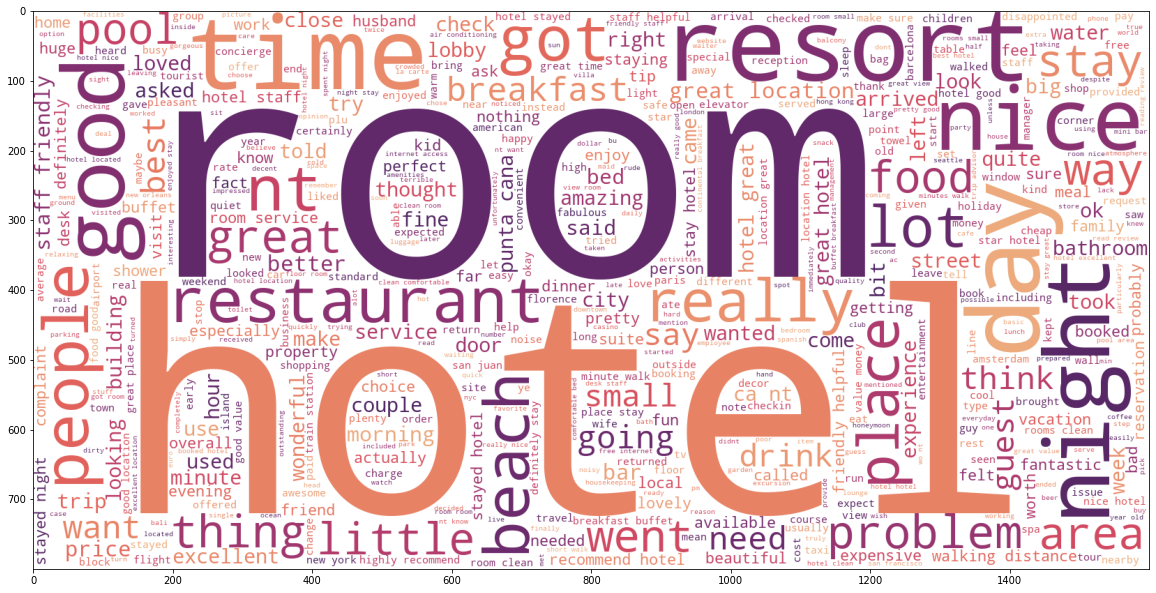

In [47]:
plt.figure(figsize=(20,20))
wc = WordCloud(max_words=1000, min_font_size=10, 
                height=800,width=1600,background_color="white", colormap='flare').generate(' '.join(df1['Review']))

plt.imshow(wc)

## Creating Wordcloud for each Rating

In [48]:
stops = stopwords.words('english') + ['hotel', 'room', 'not']

w1 = WordCloud(color_func=lambda *args, **kwargs: "#EF553B", 
               background_color='white', 
               max_words=50, 
               stopwords=stops,
               random_state=42,
               height=1000, 
               width=1000) \
            .generate(" ".join(df1[df1['Rating'] == 1]['Review']))

w2 = WordCloud(color_func=lambda *args, **kwargs: "#FFA15A", 
               background_color='white', 
               max_words=50, 
               stopwords=stops,
               random_state=42,
               height=1000, 
               width=1000) \
            .generate(" ".join(df1[df1['Rating'] == 2]['Review']))

w3 = WordCloud(color_func=lambda *args, **kwargs: "#FECB52", 
               background_color='white', 
               max_words=50, 
               stopwords=stops,
               random_state=42,
               height=1000, 
               width=1000) \
            .generate(" ".join(df1[df1['Rating'] == 3]['Review']))

w4 = WordCloud(color_func=lambda *args, **kwargs: "#B6E880", 
               background_color='white', 
               max_words=50, 
               stopwords=stops,
               random_state=42,
               height=1000, 
               width=1000) \
            .generate(" ".join(df1[df1['Rating'] == 4]['Review']))

w5 = WordCloud(color_func=lambda *args, **kwargs: "#00CC96", 
               background_color='white', 
               max_words=50,
               stopwords=stops,
               random_state=42,
               height=1000, 
               width=1000) \
            .generate(" ".join(df1[df1['Rating'] == 5]['Review']))



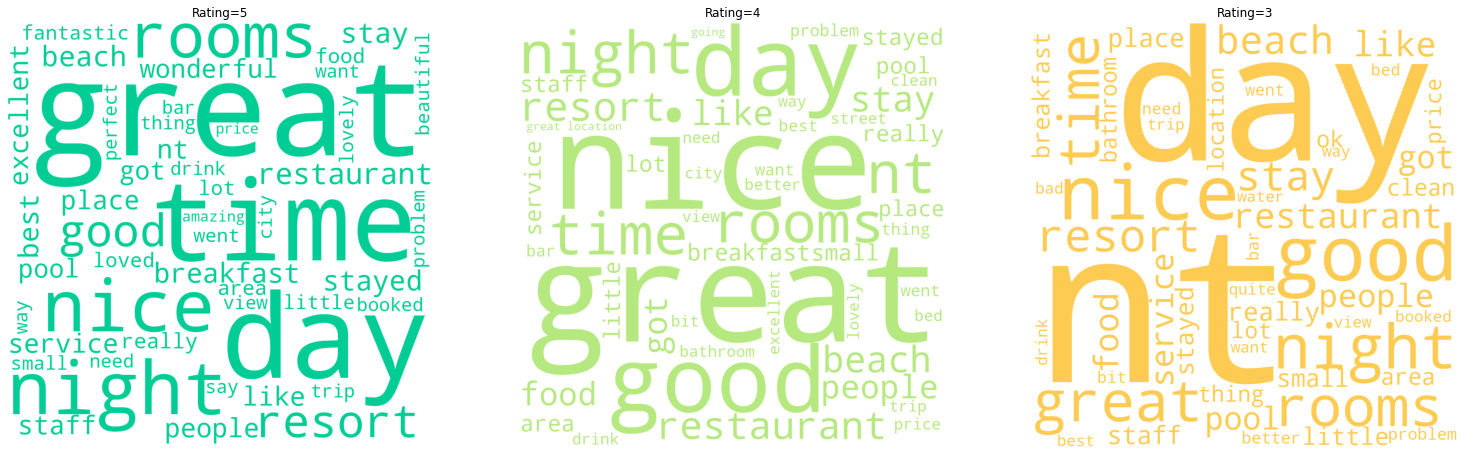

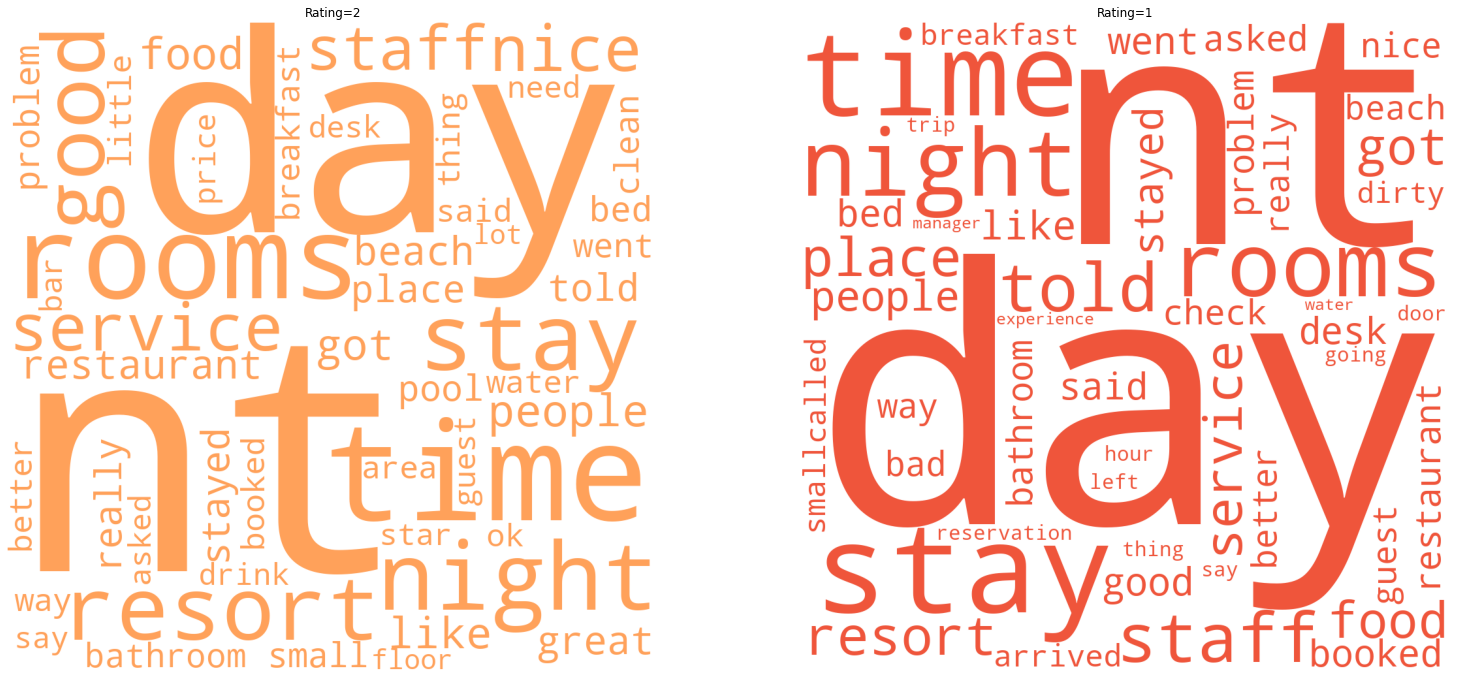

In [49]:
fig = plt.figure(figsize=(26, 12))

fig.add_subplot(1, 3, 1)
plt.axis('off')
plt.title('Rating=5')
plt.imshow(w5)

fig.add_subplot(1, 3, 2)
plt.title('Rating=4')
plt.axis('off')
plt.imshow(w4)

fig.add_subplot(1, 3, 3)
plt.axis('off')
plt.title('Rating=3')
plt.imshow(w3)

fig = plt.figure(figsize=(26, 12))


fig.add_subplot(1, 2, 1)
plt.title('Rating=2')
plt.axis('off')
plt.imshow(w2)

fig.add_subplot(1, 2, 2)
plt.title('Rating=1')
plt.axis('off')
plt.imshow(w1)

## Train-Test Split

In [50]:
X_train, X_test, y_train, y_test = train_test_split(df['Review'], df['Rating'], test_size=0.2)

## Building Model With SKLEARN

In [51]:
tfid = TfidfVectorizer()
train_tfid_matrix = tfid.fit_transform(X_train)
test_tfid_matrix = tfid.transform(X_test)

In [52]:
pickle.dump(tfid, open('tfidf.pkl', 'wb'))

In [53]:
from sklearn.linear_model import RidgeClassifier

In [54]:
models = [DecisionTreeClassifier(),
          RandomForestClassifier(),
          SVC(),
          LogisticRegression(max_iter=1000),
          KNeighborsClassifier(),
          BernoulliNB(),
          RidgeClassifier()]

In [55]:
"""accuracy = []

for model in models:
    cross_val = cross_val_score(model, train_tfid_matrix, y_train, scoring='accuracy',
                               cv=StratifiedKFold(10)).mean()
    accuracy.append(cross_val)"""

"accuracy = []\n\nfor model in models:\n    cross_val = cross_val_score(model, train_tfid_matrix, y_train, scoring='accuracy',\n                               cv=StratifiedKFold(10)).mean()\n    accuracy.append(cross_val)"

In [56]:
"""models_name = ['DecisionTreeClassifier', 'RandomForestClassifier', 'SVC',
         'LogisticRegression', 'KNeighborsClassifier', 'BernoulliNB', 'RidgeClassifier']

acc = pd.DataFrame({'Model': models_name, 'Accuracy': accuracy})                            
acc"""



"models_name = ['DecisionTreeClassifier', 'RandomForestClassifier', 'SVC',\n         'LogisticRegression', 'KNeighborsClassifier', 'BernoulliNB', 'RidgeClassifier']\n\nacc = pd.DataFrame({'Model': models_name, 'Accuracy': accuracy})                            \nacc"

Since Logistic Regression performs better than other models in this case, we will use it to train our model

In [57]:
#fig = px.funnel(acc, x=models_name, y="Accuracy")
#fig.show()

## Finalize the LogisticRegression Model

In [58]:
log = LogisticRegression(max_iter=1000)
log.fit(train_tfid_matrix, y_train)

pred = log.predict(test_tfid_matrix)

## Creating pickle file for Deployment

In [59]:
pickle.dump(log, open('ml_model.pkl', 'wb'))

## Creating Function for prediction

In [60]:
ml = pickle.load(open('ml_model.pkl','rb'))
tfidf = pickle.load(open('tfidf.pkl','rb'))
def ml_predict(text):
    clean_text = cleaning(text)
    tfid_matrix = tfidf.transform([clean_text])
    pred_proba = ml.predict_proba(tfid_matrix)
    idx = np.argmax(pred_proba)
    pred = ml.classes_[idx]
    
    return pred, pred_proba[0][idx]

ml_predict("room service is good but staff is rude")

('Negative', 0.889634747429947)

## Classification Report and Confussion Matrix

              precision    recall  f1-score   support

    Negative       0.77      0.74      0.75       610
     Neutral       0.58      0.17      0.27       443
    Positive       0.88      0.98      0.93      3046

    accuracy                           0.86      4099
   macro avg       0.75      0.63      0.65      4099
weighted avg       0.83      0.86      0.83      4099



Text(0.5, 1.0, 'Confusion Matrix for Logistic Regression Model')

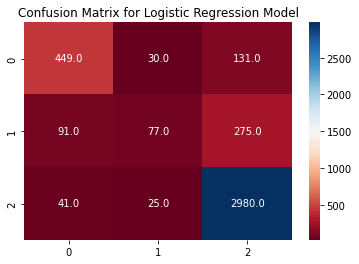

In [61]:
cm = confusion_matrix(y_test, pred)
print(classification_report(y_test, pred))

sns.heatmap(cm, annot=True, fmt = ".1f",cmap="RdBu")
plt.title("Confusion Matrix for Logistic Regression Model")

## Prediction

Let's make some prediction using the model we have trained. You can create your own reviews and let the model predict the sentiment in your text

In [62]:
def ml_predict(text):                                                                       
    clean_text = cleaning(text)
    tfid_matrix = tfid.transform([clean_text])
    pred_proba = ml.predict_proba(tfid_matrix)
    pred = log.predict(tfid_matrix)[0]
    
    return pred

In [63]:
text = 'Such a comfy place to stay with the loved one'

print('Prediction using Logistic Regression: {}'.format(ml_predict(text)))

Prediction using Logistic Regression: Positive


In [64]:
text2 = 'Awful room services and slow wifi connection'

print('Prediction using Logistic Regression: {}'.format(ml_predict(text2)))

Prediction using Logistic Regression: Negative


In [65]:
text3 = 'overall experience is nice but only wifi connection is very bad'

print('Prediction using Logistic Regression: {}'.format(ml_predict(text3)))


Prediction using Logistic Regression: Neutral


In [66]:
text4 = df['Review'][27]
print('Prediction using Logistic Regression: {}'.format(ml_predict(text4)))
text4

Prediction using Logistic Regression: Neutral


'meet expectations centrally locate hotel block water popular nightlife shop options belltown downtown classify property star location pay wed rate sure fare value proposition room spacious little outdated room decent view lower floor drab panaroma park lot build adequate fitness center sauna pool basement quaint barrestaurant attach hotel park 30 day outrage possibly standard downtown street park weekend save dollars will stay future price significantly lower nearby fourstar competition'

✈::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::

